# Single Crane as Part of a Gantry Crane: Derivation of Equations of Motion and Simulation

Strongly inspired by [Bolorkhuu Dariimaa](http://bolorkhuu.com/about.html) (2017), [Carsten Knoll](https://tu-dresden.de/ing/elektrotechnik/rst/das-institut/beschaeftigte/carsten-knoll) (2021), see [this](https://github.com/cknoll/demo-material/tree/main/underactuated_systems)

This notebook requires the python packages `ipydex` and `symbtools`. To install these, one might use:

```

!pip install ipydex symbtools

```

---


In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [3]:
from sympy.interactive import printing
printing.init_printing()

Image:

<img src="single_crane_diagram.svg">

In [21]:
t = sp.Symbol('t')
params = sp.symbols('m0, m1, m2, l1, g, d0, d1')

st.make_global(params)

# TODO: System identification -> d0, d1
parameter_values = list(dict(m0=0.557, m1=0.1, m2=0.3, l1=0.32, g=9.81,
                    d0=0.01, d1=0.01).items()) ##:


Fcomp = sp.Symbol('Fcomp')

Np = 3 # number of passive coordinates (p = phi1)
Nq = 2 # number of actuated coordinates (q = x0)
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))

# all coordinates and their derivatives
ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

tau1, tau2 = sp.symbols('tau1, tau2')

parameter_values := [('m0', 0.557),
 ('m1', 0.1),
 ('m2', 0.3),
 ('l1', 0.32),
 ('g', 9.81),
 ('d0', 0.01),
 ('d1', 0.01)]

---

---

---

---

Meaning of the variables: absolut values!

$[p_1, q_1] = [\varphi_1, x_0]$

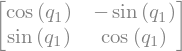

---

---

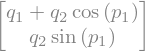

---

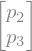

---

In [22]:
# Unit vectors in x-y-plane
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])
# Rotation matrix in x-y-plane
Rz = mt.Rz 
Rz(q1) ##:

# centers of masses -> S
# joints -> G

S0 = G0 = ex*q1 ##:
S1 = G1 = G0 + q2*Rz(p1)*ex ##:
S2 = G2 = sp.Matrix([p2, p3]) ##:

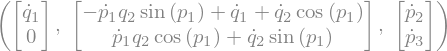

---

In [23]:
# Time derivatives of coordinates of the centers of masses
S0dt, S1dt, S2dt = st.col_split(st.time_deriv(st.col_stack(S0, S1, S2), ttheta)) ##:

In [24]:
# kinetic energy of the cart
T0 = 0.5 * m0 * qdot1**2
# kinetic energy of pendulum
T1 = 0.5 * m1 * (S1dt.T * S1dt)[0]
T2 = 0.5 * m2 * (S2dt.T * S2dt)[0]

# total kinetic energy
T = T0 + T1 + T2

q2max = 0.5
# total potential energy
V = g * (m1*(q2max + S1[1]) + m2*(q2max + l1 + S2[1]))

# viscous friction
# is implemented in external_forces instead
#R = 0.5 * d0 * qdot1**2 + 0.5 * d1 * pdot1**2

In [25]:
external_forces = [0, 0, 0, tau1, tau2]

# model generation with Lagragian Mechanics
mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[(G2[0]-G1[0])**2 + (G2[1]-G1[1])**2 - l1**2])

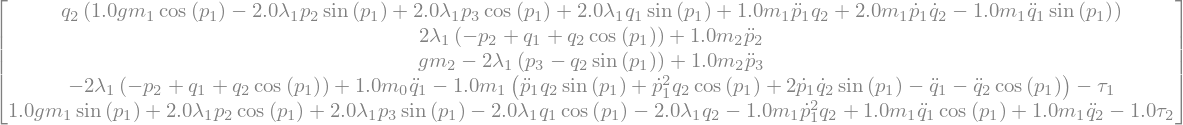

In [26]:
# implicit(=0) system equations 
mod.eqns

### Visualization of kinematics (optional, just for didactic or debug purpose)

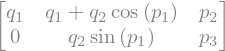

---

---

---

In [27]:
# matrix of joints
joints = sp.Matrix.hstack(G0, G1, G2) ##:
joints = joints.subs(parameter_values)
# constraints equations (implicit) as vector
constraints = mod.constraints ##:
constraints = constraints.subs(parameter_values) ##:

# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta, joints, modules="numpy")

# cost function of constraints, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def constraint_cost(theta_var, theta_const):
    err = constraints_func(theta_const[0], theta_const[1], *theta_var, theta_const[2], theta_const[3])
    return err[0]**2 # squared error

In [121]:
%matplotlib inline

init_theta = []

from ipywidgets import interact
@interact(p1=(npy.pi+0.1, 2*npy.pi, .1), p2=(-1, 1, .1), q1=(-1, 1, .1), q2=(0, q2max, .1))
def plot_func(p1, p2, q1, q2):
    res = fmin(constraint_cost, x0=[-1], args=([p1, p2, q1, q2],), disp=0, ftol=1e-15)

    # dependent coordinates
    p3, = res
    jc = joint_coords = joints_func(p1, p2, p3, q1, q2)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    init_theta[:] = [p1, p2, p3, q1, q2]
    const_err = constraints_func(*init_theta)
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p3: {p3}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

interactive(children=(FloatSlider(value=4.741592653589793, description='p1', max=6.283185307179586, min=3.2415…

#### DAE system for simulation

In [256]:
# generate numerical DAE system from implicit system equations
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [257]:
# degrees of freedom of DAE system
dae.ndof

In [258]:
# DAE's states and its derivatives
dae.yy ##:T
dae.yyd ##:T

---

---

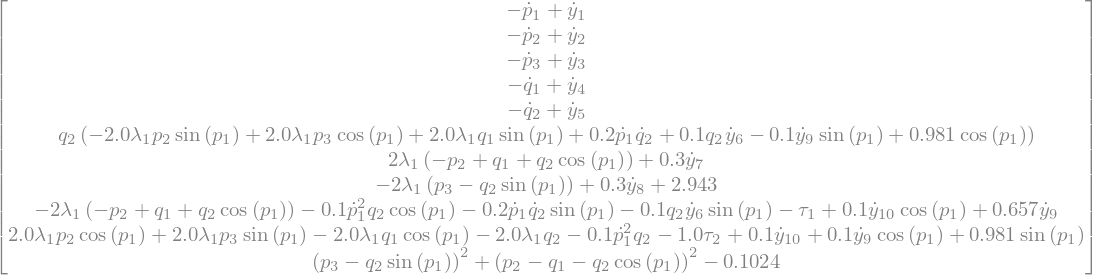

In [259]:
# implicit equations of the DAE system
dae.eqns

In [260]:
# control input vector of DAE system
dae.mod.tau

In [261]:
# define closed loop (usage of yy) control function for input
integral_error = 0
q2_init = 0.2
def new_input_func(yy, t):
    u1 = 0
    
    global integral_error
    if abs(integral_error) < 10:
        integral_error = integral_error + (q2_init - yy[4])
    else:
        integral_error = integral_error
    u2 = 100*(q2_init - yy[4]) - 40*yy[9] + 0.4*integral_error
    
    return [u1, u2]

# set as input of DAE system
dae.input_func = new_input_func ##:

(dae.input_func) := <function __main__.new_input_func(yy, t)>

---

In [262]:
### check error of constraints for initial values
dae.constraints_func(*init_theta) ##:

# calculate consistent initial values from latest visualization
yy0, yyd0 = dae.calc_consistent_init_vals(p1=init_theta[0], p2=init_theta[1], q1=init_theta[3], q2=init_theta[4], _ftol=1e-9) ##:

t0 = 0

# evaluation of implicit DAE System (should be almost 0 if initial values fulfill the model)
dae.model_func(t0, yy0, yyd0) ##:

# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

(dae.constraints_func(*init_theta)) := array(9.97533728e-09)

---

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38


(yy0, yyd0) := (array([5.04159   , 0.2       , 0.10070943, 0.        , 0.2       , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   0.        ,   0.        ,   0.        ,   0.        , -15.85723009,   0.        ,  -9.81      ,   0.        ,   9.28321228,   0.        ]))

---

(dae.model_func(t0, yy0, yyd0)) := array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.22044605e-17,  0.00000000e+00,  0.00000000e+00,  5.55111512e-17,  0.00000000e+00, -1.15038741e-15])

---

In [263]:
# defining assimulo problem
model = Overdetermined_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'single crane'

# indicate which components of y are differential (1) and which are purely algebraic (0)
model.algvar = dae.diff_alg_vars ##:

# definition of simulation of DAE system with ODASSL solver
sim = SOLVER(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

---

In [264]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# simulation of DAE system
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: single crane 

 Number of steps                           : 4899
 Number of function evaluations            : 10175
 Number of Jacobian evaluations            : 3167
 Number of error test failures             : 19
 Number of nonlinear convergence failures  : 1028

Solver options:

 Solver                  : ODASSL 
 Tolerances (absolute)   : [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e+07]
 Tolerances (relative)   : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 28.404462049000358 seconds.


In [265]:
# trajectories of coordinates and its velocities
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'dot theta')

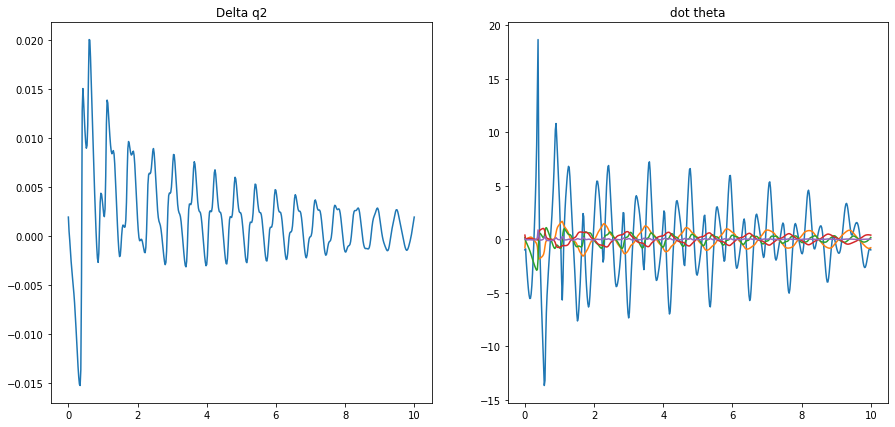

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol[:, 4] - q2_init)
ax1.set_title("Delta q2")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("dot theta")

####  Visualization and Animation of simulation solution

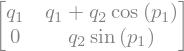

---

In [267]:
joint_pos_expr = st.col_stack(G0, G1).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

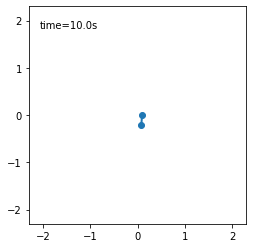

In [268]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())